# Лабораторная работа №7 Предсказание пола клиента по транзакциям

## Рязанов Егор

### Считывание данных

### Описание задачи

Одним из самых ценных источников информации о клиенте являются данные о банковских транзакциях. В этом задании предлагается ответить на вопрос: возможно ли предсказать пол клиента, используя сведения о поступлениях и тратах по банковской карте? И если возможно, то какая точность такого предсказания?

Оригинальная постановка задачи: https://www.kaggle.com/competitions/python-and-analyze-data-final-project

### Описание данных

**transactions.csv** - таблица содержит историю транзакций клиентов банка за один год и три месяца.

* customer_id - идентификатор клиента

* tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)

* mcc_code - mcc-код транзакции

* tr_type - тип транзакции

* amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту (приходная транзакция), "-" — списание средств (расходная транзакция)

* term_id - идентификатор терминала

**gender_train.csv** - таблица содержит информацию по полу для части клиентов, для которых он известен.

* customer_id - идентификатор клиента

* gender - пол клиента

**gender_test_kaggle_sample_submission.csv** - пример файла для загрузки решения на Kaggle. Структура таблицы аналогична gender_train.csv

**tr_mcc_codes.csv** - таблица содержит описание mcc-кодов транзакций.

* mcc_code - mcc-код транзакции
* mcc_description - описание mcc-кода транзакции

**tr_types.csv** - таблица содержит описание типов транзакций.

* tr_type - тип транзакции
* tr_description - описание типа транзакции

**gender_pred_sample.csv** - пример файла решения.

* customer_id - идентификатор клиента
* probability - вероятность принадлежности к полу "1"

In [6]:
import pandas as pd
import numpy as np

import xgboost as xgb
import re
import matplotlib.pyplot as plt

from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')

### Подготовка данных

In [9]:
tr_mcc_codes = pd.read_csv('./data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('./data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('./data/transactions.csv', index_col='customer_id')
print(transactions.describe())
gender_train = pd.read_csv('./data/gender_train.csv', index_col='customer_id')
gender_test = pd.DataFrame(columns=['gender'], index = list(set(transactions.index) - set(gender_train.index)))

transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')
print(f'Всего уникальных клиентов: {transactions.index.nunique()}')
print(f'Всего уникальных клиентов с известным полом (train): {transactions_train.index.nunique()}')
print(f'Всего уникальных клиентов с неизвестным полом (test): {transactions_test.index.nunique()}')

           mcc_code       tr_type        amount
count  6.849346e+06  6.849346e+06  6.849346e+06
mean   5.589776e+03  2.517356e+03 -2.054285e+04
std    6.035857e+02  2.270108e+03  4.777528e+05
min    7.420000e+02  1.000000e+03 -1.459845e+08
25%    5.200000e+03  1.030000e+03 -2.245916e+04
50%    5.641000e+03  1.110000e+03 -5.480030e+03
75%    6.010000e+03  2.370000e+03 -1.122960e+03
max    9.402000e+03  8.146000e+03  1.459845e+08
Всего уникальных клиентов: 15000
Всего уникальных клиентов с известным полом (train): 8400
Всего уникальных клиентов с неизвестным полом (test): 6600


In [10]:
transactions

,tr_datetime,mcc_code,tr_type,amount,term_id
customer_id,,,,,
39026145,0 10:23:26,4814,1030,-2245.92,NaN
39026145,1 10:19:29,6011,7010,56147.89,NaN
39026145,1 10:20:56,4829,2330,-56147.89,NaN
39026145,1 10:39:54,5499,1010,-1392.47,NaN
39026145,2 15:33:42,5499,1010,-920.83,NaN
...,...,...,...,...,...
61870738,453 16:03:02,5499,1010,-5176.84,10217113
61870738,454 10:54:60,5411,1010,-1652.77,022915
61870738,454 14:23:59,5499,1010,-4687.23,10217113


### Формирование признаков

In [11]:
for df in [transactions_train, transactions_test]:
    df['weekday'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['isday'] = df['hour'].between(6, 22).astype(int)

transactions_train.sample

<bound method NDFrame.sample of               tr_datetime  mcc_code  tr_type     amount   term_id  gender  \
customer_id                                                                 
22899          1 15:26:45      4814     1030   -4491.83       NaN       1   
22899          2 20:52:48      4814     1030   -2245.92       NaN       1   
22899          5 18:52:19      6011     2010  -44918.32       NaN       1   
22899          6 12:28:22      6011     2010 -150476.36       NaN       1   
22899         28 10:41:01      6010     7030   33688.74       NaN       1   
...                   ...       ...      ...        ...       ...     ...   
99999680     444 00:00:00      5411     1110   -5659.71  31190432       1   
99999680     444 00:00:00      6011     2110 -134754.95    406826       1   
99999680     446 00:00:00      5541     1110  -11229.58   J038003       1   
99999680     451 09:56:17      6010     7070    1122.96    945022       1   
99999680     456 06:28:00      4814     1030

In [12]:
def features_creation(x): 
    '''Формирование признаков по каждому пользователю'''
    
    features = []

    features.append(pd.Series(x['weekday'].value_counts(normalize=True).add_prefix('weekday_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['isday'].value_counts(normalize=True).add_prefix('isday_')))
    
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    return pd.concat(features)

In [13]:
data_train = transactions_train.groupby(transactions_train.index).apply(features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index).apply(features_creation).unstack(-1)

### Построение модели

In [14]:
def cv_score(params, train, y_true):
    '''Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)'''
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print(f'Cross-validation, ROC AUC: {cv_res.loc[index_argmax]["test-auc-mean"]:.3f}+-{cv_res.loc[index_argmax]["test-auc-std"]:.3f}')
    print(f'Trees: {index_argmax}')

In [15]:
def fit_predict(params, num_trees, train, test, target):
    '''Построение модели + возврат результатов классификации тестовых пользователей'''
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

In [16]:
def draw_feature_importances(clf, top_k=10):
    '''Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
    в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
    '''
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [17]:
# Стандартные параметры модели

params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

### Отрисовка решения

In [18]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.684+-0.009
Trees: 95


In [19]:
clf, submission = fit_predict(params, 180, data_train, data_test, target)

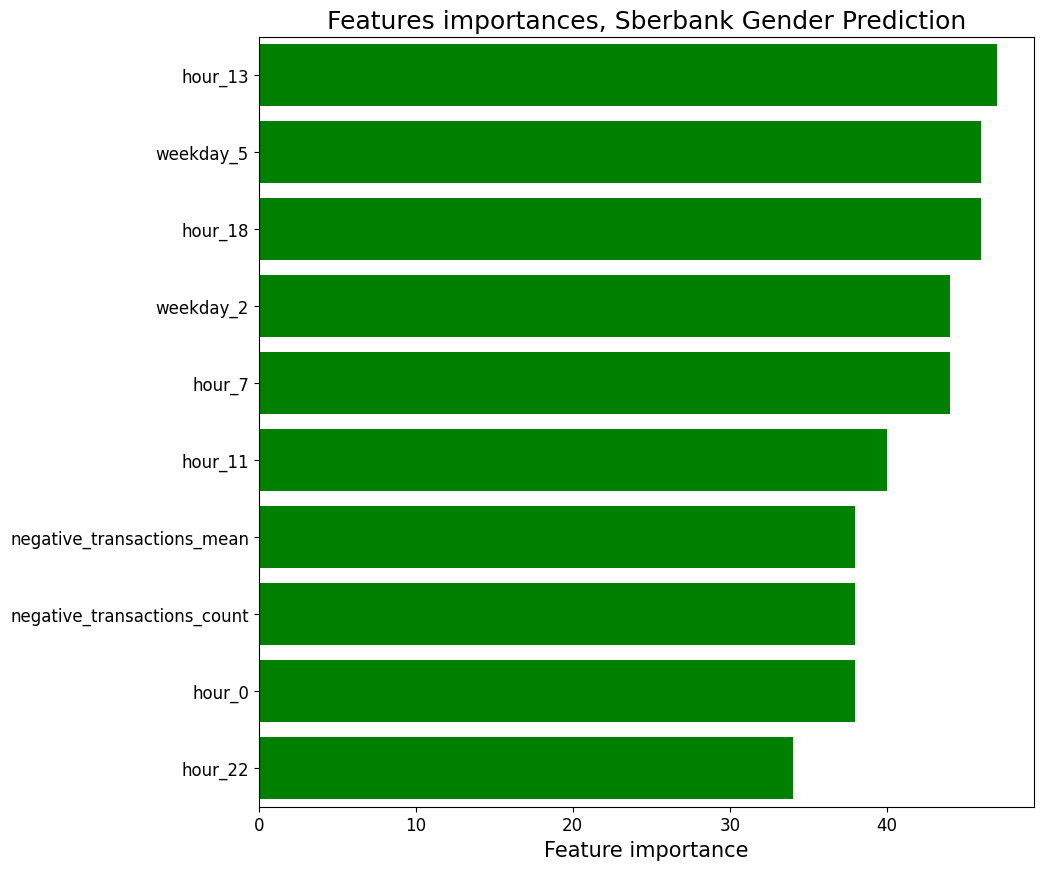

In [20]:
draw_feature_importances(clf, 10)

# Задания

# Задание 1. Связать номер дня с календарем


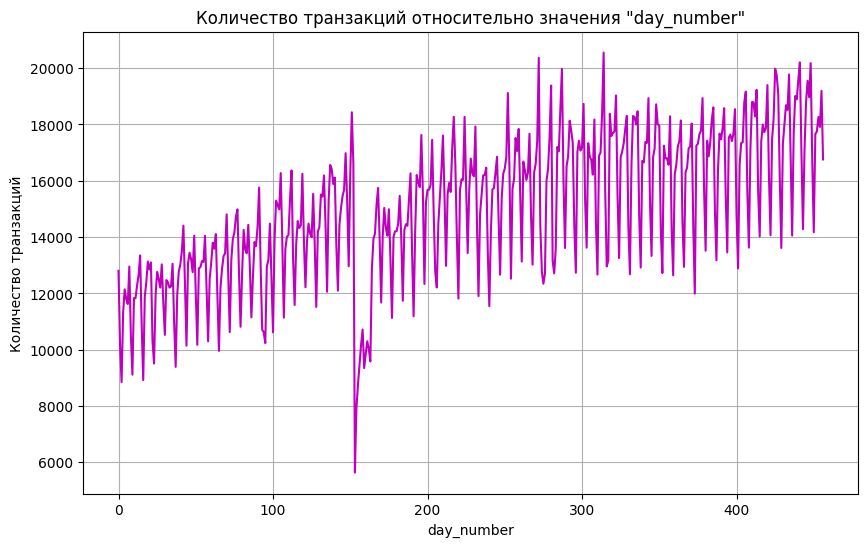

In [30]:
df = transactions

df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

df['day_number'] = df['day_number'].astype(int)

transaction_counts = df.groupby('day_number').size()

plt.figure(figsize=(10, 6))
plt.plot(transaction_counts.index, transaction_counts.values, marker=None, linestyle='-', color='m')
plt.title('Количество транзакций относительно значения "day_number"')
plt.xlabel('day_number')
plt.ylabel('Количество транзакций')
plt.grid(True)
plt.show()

Основные параметры:
- Количество дней между 1 января и 14 февраля = 45
- Количество дней между 1 января и 23 февраля = 54
- Количество дней между 1 января и 8 марта = 67, или 68 в високосный год
- Количество дней между 1 января и 1 сентября = 243, или 244 в високосный год

MCC-коды транзакций:
- 5921: Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)
- 5813: Бары, коктейль-бары, дискотеки, ночные клубы и таверны — места продажи алкогольных напитков
- 5621: Готовая женская одежда
- 5631: Аксессуары для женщин
- 5532: Автошины
- 5533: Автозапчасти и аксессуары
- 5541: Станции техобслуживания
- 5542: Автоматизированные бензозаправки
- 5571: Продажа мотоциклов
- 5599: Продажа снегоходов
- 5943: Магазины офисных, школьных принадлежностей, канцтоваров
- 5977: Магазины косметики

In [22]:
df = transactions

df['day_number'] = df['tr_datetime'].str.split(' ', expand=True)[0]

df['day_number'] = df['day_number'].astype(int)

transaction_counts = df.groupby('day_number').size()

days_with_more_than_19000 = transaction_counts[transaction_counts > 19800].index

print("Номера дней с более чем 19000 транзакций:", days_with_more_than_19000)

days_with_less_than_8000 = transaction_counts[transaction_counts < 8000].index
print("Номера дней с менее чем 8000 транзакций:", days_with_less_than_8000)

Номера дней с более чем 19000 транзакций: Index([272, 287, 314, 425, 441, 448], dtype='int64', name='day_number')
Номера дней с менее чем 8000 транзакций: Index([153, 154], dtype='int64', name='day_number')


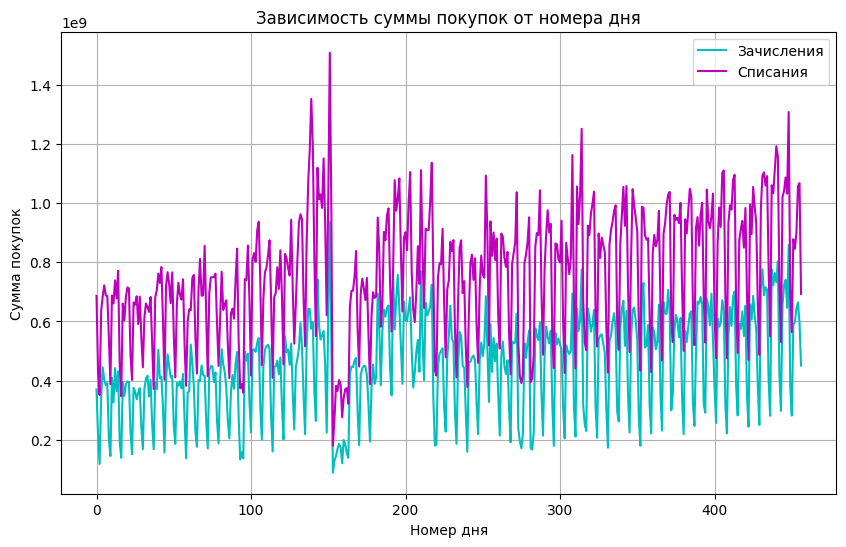

In [29]:
positive_df = df[df['amount'] > 0]
negative_df = df[df['amount'] < 0]

negative_df['amount'] = -negative_df['amount']

positive_amounts = positive_df.groupby('day_number')['amount'].sum()
negative_amounts = negative_df.groupby('day_number')['amount'].sum()

plt.figure(figsize=(10, 6))

plt.plot(positive_amounts.index, positive_amounts.values, label='Зачисления', linestyle='-', color='c')

plt.plot(negative_amounts.index, negative_amounts.values, label='Списания', linestyle='-', color='m')

plt.title('Зависимость суммы покупок от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма покупок')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
days_with_negative_amounts_greater_than_1_2 = negative_amounts[negative_amounts > 1200000000].index

print("Дни, в которые сумма трат была больше 1.2:", days_with_negative_amounts_greater_than_1_2)

Дни, в которые сумма трат была больше 1.2: Index([139, 151, 314, 448], dtype='int64', name='day_number')


## Нахождение 1-го сентября

- MCC-код 5943: магазины офисных, школьных принадлежностей, канцтоваров

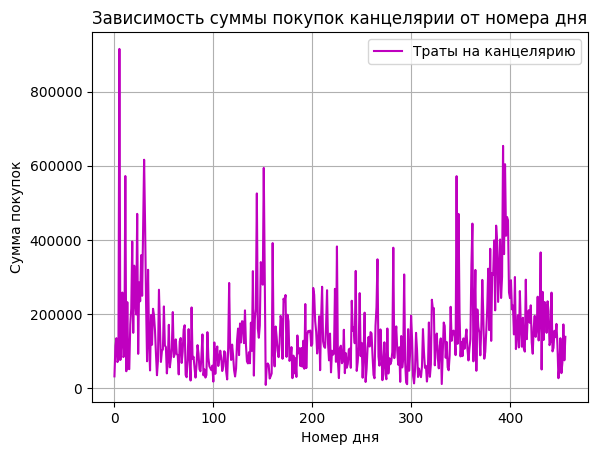

In [37]:
filtered_transactions = df[(df['mcc_code'] == 5943) & (df['amount'] < 0)]

school_time = filtered_transactions.groupby('day_number')['amount'].sum()

school_time = school_time.abs()

plt.plot(school_time.index, school_time.values, label='Траты на канцелярию', linestyle='-', color='m')

plt.title('Зависимость суммы покупок канцелярии от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма покупок')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
first_sept = school_time[school_time > 600000].index

print("Предположительный конец августа:", first_sept)

Предположительный конец августа: Index([5, 30, 393, 395], dtype='int64', name='day_number')


## Нахождение 8-го марта

- MCC-код 5193: Оборудование для выращивания растений, инвентарь для питомников и цветы

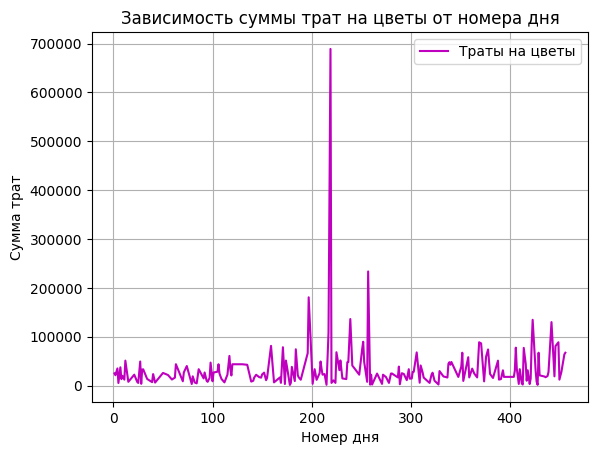

In [39]:
filtered_transactions = df[(df['mcc_code'] == 5193) & (df['amount'] < 0)]

March = filtered_transactions.groupby('day_number')['amount'].sum()

March = March.abs()

plt.plot(March.index, March.values, label='Траты на цветы', linestyle='-', color='m')

plt.title('Зависимость суммы трат на цветы от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
flover_time = March[March > 600000].index

print("Предположительное 8 марта:", flover_time)

Предположительное 8 марта: Index([219], dtype='int64', name='day_number')


- 219-ый день: 8-ое Марта
- Разница между 8-ым марта и 153-ым днем равна 66 дней, это как раз является разницей между 1-ым января и 8-ым марта
- Отнимем от 1 января 153 дня и получим 1-ое августа, следовательно, датасет начинается с **1-го августа**

## Нахождение дня недели

- MCC-код 5921: Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)

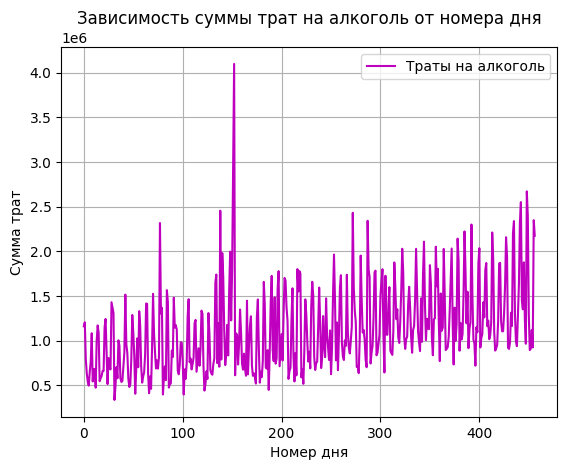

In [43]:
filtered_transactions = df[(df['mcc_code'] == 5921) & (df['amount'] < 0)]


Alcohol = filtered_transactions.groupby('day_number')['amount'].sum()

Alcohol = Alcohol.abs()

plt.plot(Alcohol.index, Alcohol.values, label='Траты на алкоголь', linestyle='-', color='m')

plt.title('Зависимость суммы трат на алкоголь от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
New_year = Alcohol[Alcohol > 3000000].index

print("Предположительный Новый Год:", New_year)

Предположительный Новый Год: Index([151, 152], dtype='int64', name='day_number')


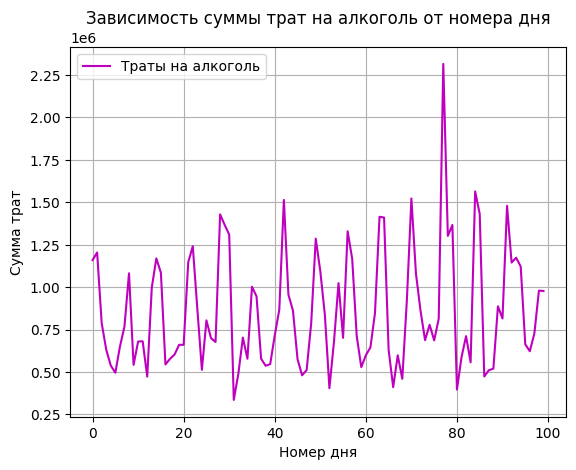

In [45]:
Alcohol_100 = Alcohol.head(100)

plt.plot(Alcohol_100.index, Alcohol_100.values, label='Траты на алкоголь', linestyle='-', color='m')

plt.title('Зависимость суммы трат на алкоголь от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма трат')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
fridays = Alcohol_100[Alcohol_100 > 1010000].index

print("Предположительные пятницы:", fridays)

Предположительные пятницы: Index([ 0,  1,  8, 14, 15, 21, 22, 28, 29, 30, 42, 49, 50, 54, 56, 57, 63, 64,
       70, 71, 77, 78, 79, 84, 85, 91, 92, 93, 94],
      dtype='int64', name='day_number')


- Скорее всего 2 рядом стоящих дня - это пятница и суббота, следовательно, значит 14-ое, 21-ое, 28-ое - пятницы, а 8-ое и 1-ое - суббота.
- Получаем начало отсчёта: **пятница 1-го августа**

## Нахождение года начала отсчёта

- В 2008-ом и 2014-ом году 1-оее августа было пятницей
- Между 8-ым марта и 1-ым января 66 дней, значит следующий за годом начала отсчёта год - не високосный, следовательно 2008-ой год - високосный, а 2014 -нет
- Предположим, что в 2014-ом году в Сочи была Олимпиада, значит с 7-го по 23-ие февраля должен быть большое скачок продажи сувениров, 7-23-ие февраля - это 190-206-ые дни

- MCCкод 5947: Магазины открыток, подарков, новинок и сувениров

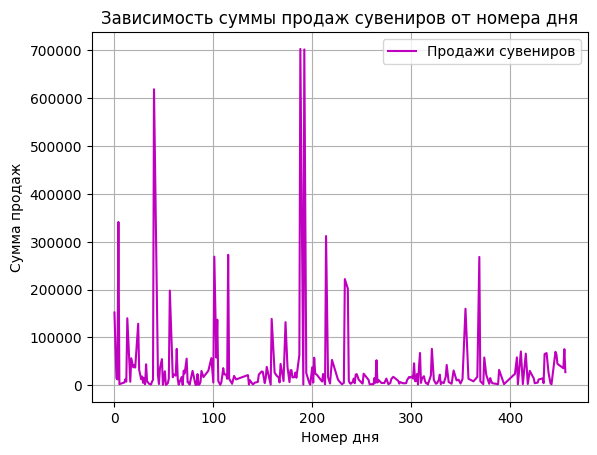

In [48]:
filtered_transactions = df[(df['mcc_code'] == 7372) & (df['amount'] < 0)]

Souvenir = filtered_transactions.groupby('day_number')['amount'].sum()

Souvenir = Souvenir.abs()

plt.plot(Souvenir.index, Souvenir.values, label='Продажи сувениров', linestyle='-', color='m')

plt.title('Зависимость суммы продаж сувениров от номера дня')
plt.xlabel('Номер дня')
plt.ylabel('Сумма продаж')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
Souvenir_top = Souvenir[Souvenir > 2000000].index

print("Предположительные пятницы:", Souvenir_top)

Предположительные пятницы: Index([], dtype='int64', name='day_number')


- Ответ: пятница 1-го августа 2014 года

# Задание 2. Декодировать суммы поступлений и списаний

In [50]:
filtered_amounts = df[(df['tr_type'] == 2010) & (df['amount'] < 0)]['amount']
unique_amounts = filtered_amounts.unique()
sorted_unique_amounts = pd.Series(unique_amounts).astype(float).sort_values()

differences = sorted_unique_amounts.diff()

print(differences)
differences_counts = differences.value_counts()

top_10_differences = differences_counts.head(10)
print("Топ-10 самых частых разностей:")
print(top_10_differences)

661          NaN
206     36755.54
566     89836.63
272     22459.15
1207    67377.48
          ...   
0        1122.96
962        94.78
112      1028.18
46       1122.95
21       1122.96
Length: 1332, dtype: float64
Топ-10 самых частых разностей:
2245.92     146
2245.92      85
2245.91      75
2245.91      69
1122.96      68
1122.96      64
4491.83      54
1122.96      39
11229.58     38
2245.91      37
Name: count, dtype: int64


- 2245.92 - это, вероятно, 100 рублей, а 1122.96 - это 50 рублей, а значит коэффициент равен **22.4592**

# Задание 3. Соотнести 0 и 1 к полу

- MCС-код 5977: Магазины косметики

In [51]:
people_df = pd.read_csv('./data/gender_train.csv')
merged_table = pd.merge(transactions, people_df, on='customer_id')
merged_table

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN,0,1
1,39026145,1 10:19:29,6011,7010,56147.89,NaN,1,1
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN,1,1
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN,1,1
4,39026145,2 15:33:42,5499,1010,-920.83,NaN,2,1
...,...,...,...,...,...,...,...,...
3751078,61870738,453 16:03:02,5499,1010,-5176.84,10217113,453,0
3751079,61870738,454 10:54:60,5411,1010,-1652.77,022915,454,0
3751080,61870738,454 14:23:59,5499,1010,-4687.23,10217113,454,0
3751081,61870738,454 16:11:53,5541,1110,-4491.83,RU570124,454,0


In [52]:
cosmetics = merged_table[merged_table['mcc_code'] == 5977] 
cosmetics.drop_duplicates(subset='customer_id', inplace=True)
cosmetics

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
2140,1585299,90 09:42:30,5977,1010,-3571.68,NaN,90,1
3035,5524414,423 09:18:22,5977,1010,-2335.75,083385,423,0
3276,35059129,76 14:31:42,5977,1010,-4491.83,NaN,76,0
4387,3765322,95 18:54:19,5977,1110,-49072.59,NaN,95,0
6194,41870088,138 19:36:24,5977,1110,-48498.31,NaN,138,1
...,...,...,...,...,...,...,...,...
3745166,93176546,7 13:40:08,5977,1010,-16080.76,NaN,7,1
3745905,22566303,54 00:00:00,5977,1110,-11386.79,NaN,54,0
3747280,53455317,388 00:00:00,5977,1110,-2964.61,00350234,388,0
3748871,90011720,126 15:48:31,5977,1110,-42649.94,NaN,126,0


In [53]:
gender_1_c = (cosmetics['gender'] == 1).sum()
gender_0_c = (cosmetics['gender'] == 0).sum()

print('0:', gender_0_c, '1:', gender_1_c)

0: 2294 1: 1111


- По результату вывода, косметики больше у гендера 0. Предположение - это женщины. Проверим наше предположение на MCC-коде 5631: Аксессуары для женщин

In [54]:
accessories = merged_table[merged_table['mcc_code'] == 5631] 
accessories.drop_duplicates(subset='customer_id', inplace=True)
accessories

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day_number,gender
3878,35059129,303 00:00:00,5631,1110,-6063.97,20454635,303,0
4814,3765322,377 17:02:02,5631,1110,-66771.08,26303362,377,0
10951,64294802,204 00:00:00,5631,1110,-12240.24,NaN,204,1
23488,2368868,12 16:24:04,5631,1010,-30656.75,NaN,12,0
26967,3180911,13 16:58:22,5631,1010,-2021.32,NaN,13,0
...,...,...,...,...,...,...,...,...
3728121,49446707,420 00:00:00,5631,1110,-67377.47,26303891,420,1
3738788,42445327,287 22:02:45,5631,1010,-35912.19,241140,287,0
3740156,87780866,225 00:00:00,5631,1110,-1482.30,29039219,225,0
3743844,9745595,376 15:52:46,5631,1110,-44806.02,50122942,376,0


In [55]:
gender_1_a = (accessories['gender'] == 1).sum()
gender_0_a = (accessories['gender'] == 0).sum()

print('0:', gender_0_a, '1:', gender_1_a)

0: 664 1: 205


- Предпложение подтверждается

- Ответ: 0 - это женщины, 1 - это мужчины